# Google colab commands

In [1]:
!git clone https://github.com/Francesco9932/financial-sentiment-analysis

Cloning into 'financial-sentiment-analysis'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 97 (delta 30), reused 34 (delta 13), pack-reused 42
Unpacking objects: 100% (97/97), 112.32 MiB | 11.49 MiB/s, done.


In [2]:
%cd financial-sentiment-analysis/

/content/financial-sentiment-analysis


In [3]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-06-06 11:43:05--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-06-06 11:43:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-06-06 11:43:05--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [4]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [5]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.9 MB/s eta 0:00:00


# Import

In [6]:
from transformers import TFDistilBertModel
from transformers import DistilBertTokenizer
import pandas as pd
import numpy as np

# pre-processing
from sklearn.preprocessing import LabelEncoder
from nltk.stem.porter import *
from nltk.corpus import stopwords
import re
import nltk 
nltk.download("stopwords")

from transformers import BertTokenizer
from transformers import TFBertModel
import tensorflow as tf
from keras.utils import pad_sequences
import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data preprocessing

In [128]:
df = pd.read_csv('all-data.csv', encoding="latin-1",
                 names=['sentiment', 'headline'])
df.head()

,sentiment,headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [130]:
print("original shape: ", df.shape)
df = df.drop_duplicates()
print("after drop duplicates shape: ", df.shape)
dd_dn = df.dropna()
print("after drop null shape: ", df.shape)

original shape:  (4840, 2)
after drop duplicates shape:  (4840, 2)
after drop null shape:  (4840, 2)


In [131]:
df.isnull().sum() 

sentiment    0
headline     0
dtype: int64

neutral     59.4
positive    28.2
negative    12.5
Name: sentiment, dtype: float64


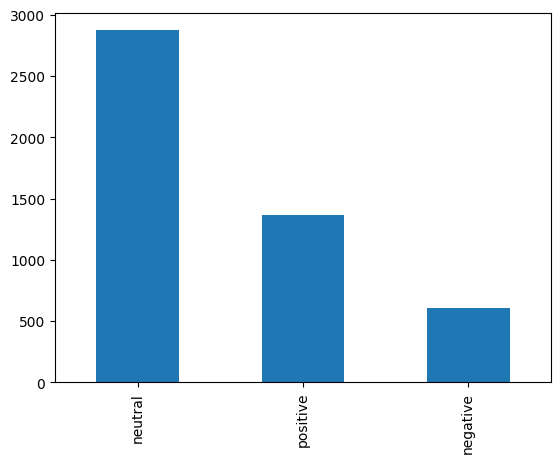

In [132]:
df['sentiment'].value_counts().plot(kind='bar')
class_percentage = df['sentiment'].value_counts() / len(df) * 100
print(round(class_percentage, 1))

In [133]:
import string
def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # words = text.split()
    # words = [w for w in words if w not in stopwords.words("english")]
    return text

df['headline'] = df['headline'].apply(preprocess)
#df.to_csv('preprocessed.csv', index=False)

In [ ]:
# Positive tweet
print("Positive news headline example :",df[df['sentiment']=='positive']['headline'].values[1])
#negative_text
print("Negative news headline example :",
      df[df['sentiment'] == 'negative']['headline'].values[1])
#neutral_text
print("Neutral news headline example  :",df[df['sentiment']=='neutral']['headline'].values[1])

In [127]:
sentences = df['headline'].to_list()

# Encode target labels
le = LabelEncoder()
le.fit(df['sentiment'])
df['sentiment'] = le.transform(df['sentiment'])
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [64]:
from matplotlib import pyplot as plt

def plot_train_val_acc(history, title, acc_metric):
    plt.plot(history.history[acc_metric])
    plt.plot(history.history["val_"+acc_metric])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')

    # Ottenere il valore massimo di val_accuracy e l'epoca corrispondente
    max_val_acc = max(history.history['val_accuracy'])
    epoch_with_max_val_acc = history.history['val_accuracy'].index(max_val_acc)

    # Aggiungere un'etichetta per il valore massimo di val_accuracy nel grafico
    plt.annotate(f'Max Val Acc: {max_val_acc:.4f}',
                 xy=(epoch_with_max_val_acc, max_val_acc),
                 xytext=(epoch_with_max_val_acc, max_val_acc + 0.05),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))

    # Impostare gli intervalli dell'asse x come interi
    plt.xticks(range(len(history.history[acc_metric])))

    plt.show()



# Tokenizer for other models

In [13]:
tokenizer = keras.preprocessing.text.Tokenizer(lower=True)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
word_index = tokenizer.word_index
print("Vocab length:", len(word_index) + 1)

max_seq_length = np.max(list(map(lambda x: len(x), sequences)))
print("Maximum sequence length:", max_seq_length)
sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

Vocab length: 10094
Maximum sequence length: 71


In [14]:
train_sequences, test_sequences, y_train, y_test = train_test_split(sequences, df['sentiment'], train_size=0.7, shuffle=True, random_state=42)

In [15]:
print('Train Set ->', train_sequences.shape, y_train.shape)
print('Test Set ->', test_sequences.shape, y_test.shape)

Train Set -> (3388, 71) (3388,)
Test Set -> (1452, 71) (1452,)


# Global Vectors for Word Representation (GloVe)

In [16]:
vocab_size = 10123
embedding_size = 200

embeddings_index = {}

with open('glove.6B.200d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


embeddings_matrix = np.zeros((vocab_size+1, embedding_size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [17]:
print(embeddings_matrix.shape)

(10124, 200)


# CNN1d Model

In [42]:
inputs = tf.keras.Input(shape=(train_sequences.shape[1],))
x = tf.keras.layers.Embedding(input_dim=vocab_size+1,
                              output_dim=embedding_size,
                              input_length=train_sequences.shape[1],
                              weights=[embeddings_matrix])(inputs)

convs = []
filter_sizes = [2,3,4,5,6]

for filter_size in filter_sizes:
    l_conv = tf.keras.layers.Conv1D(filters=200, 
                        kernel_size=filter_size, 
                        activation='relu')(x)
    l_pool = tf.keras.layers.GlobalMaxPooling1D()(l_conv)
    convs.append(l_pool)

l_merge = tf.keras.layers.concatenate(convs, axis=1)
x = tf.keras.layers.Dropout(0.1)(l_merge)  
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 71)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 71, 200)      2024800     ['input_3[0][0]']                
                                                                                                  
 conv1d_5 (Conv1D)              (None, 70, 200)      80200       ['embedding_2[0][0]']            
                                                                                                  
 conv1d_6 (Conv1D)              (None, 69, 200)      120200      ['embedding_2[0][0]']            
                                                                                            

In [43]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./best_model/best_model_cnn1d.h5', 
                     monitor='val_accuracy', mode='max', verbose=1, 
                     save_best_only=True)

history = model.fit(train_sequences,
                    y_train,
                    batch_size=32,
                    epochs=100, 
                    validation_split=0.1,
                    callbacks=[es, mc])

Epoch 1/100
96/96 [==============================] - ETA: 0s - loss: 0.9026 - accuracy: 0.6245
Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to ./best_model/best_model_cnn1d.h5
96/96 [==============================] - 22s 193ms/step - loss: 0.9026 - accuracy: 0.6245 - val_loss: 0.7138 - val_accuracy: 0.6667
Epoch 2/100
96/96 [==============================] - ETA: 0s - loss: 0.5430 - accuracy: 0.7809
Epoch 2: val_accuracy did not improve from 0.66667
96/96 [==============================] - 11s 109ms/step - loss: 0.5430 - accuracy: 0.7809 - val_loss: 0.8018 - val_accuracy: 0.6667
Epoch 3/100
96/96 [==============================] - ETA: 0s - loss: 0.2744 - accuracy: 0.9006
Epoch 3: val_accuracy improved from 0.66667 to 0.70501, saving model to ./best_model/best_model_cnn1d.h5
96/96 [==============================] - 4s 43ms/step - loss: 0.2744 - accuracy: 0.9006 - val_loss: 0.6562 - val_accuracy: 0.7050
Epoch 4/100
96/96 [==============================] - ETA: 0s - 

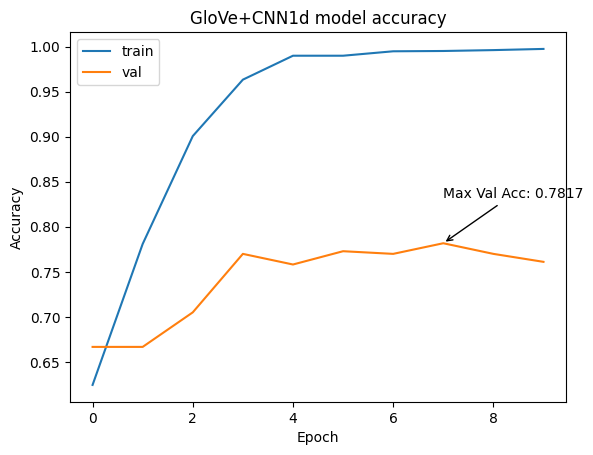

In [47]:
plot_train_val_acc(history, "GloVe+CNN1d model accuracy", "accuracy")

In [139]:
saved_model = load_model('./best_model/best_model_cnn1d.h5')
# Classification report:
predicted = saved_model.predict(test_sequences)
y_predicted = np.argmax(predicted, axis=1)
print(classification_report(y_test, y_predicted))

46/46 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.76      0.66      0.71       183
           1       0.82      0.90      0.86       839
           2       0.74      0.65      0.69       430

    accuracy                           0.79      1452
   macro avg       0.77      0.73      0.75      1452
weighted avg       0.79      0.79      0.79      1452



# LSTM Model

In [66]:
inputs = tf.keras.Input(shape=(train_sequences.shape[1],))
x = tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_size,
                              input_length=train_sequences.shape[1])(inputs)
x = tf.keras.layers.LSTM(256, return_sequences=True, activation='tanh')(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 71)]              0         
                                                                 
 embedding_5 (Embedding)     (None, 71, 200)           2024600   
                                                                 
 lstm_3 (LSTM)               (None, 71, 256)           467968    
                                                                 
 flatten_3 (Flatten)         (None, 18176)             0         
                                                                 
 dense_13 (Dense)            (None, 3)                 54531     
                                                                 
Total params: 2,547,099
Trainable params: 2,547,099
Non-trainable params: 0
_________________________________________________________________


In [51]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./best_model/best_model_lstm.h5', 
                     monitor='val_accuracy', mode='max', verbose=1, 
                     save_best_only=True)

history = model.fit(train_sequences,
                    y_train,
                    batch_size=32,
                    epochs=100, 
                    validation_split=0.1,
                    callbacks=[es, mc])

Epoch 1/100
96/96 [==============================] - ETA: 0s - loss: 0.8138 - accuracy: 0.6537
Epoch 1: val_accuracy improved from -inf to 0.67257, saving model to ./best_model/best_model_lstm.h5
96/96 [==============================] - 16s 143ms/step - loss: 0.8138 - accuracy: 0.6537 - val_loss: 0.7787 - val_accuracy: 0.6726
Epoch 2/100
96/96 [==============================] - ETA: 0s - loss: 0.4064 - accuracy: 0.8455
Epoch 2: val_accuracy improved from 0.67257 to 0.70501, saving model to ./best_model/best_model_lstm.h5
96/96 [==============================] - 5s 57ms/step - loss: 0.4064 - accuracy: 0.8455 - val_loss: 0.7525 - val_accuracy: 0.7050
Epoch 3/100
96/96 [==============================] - ETA: 0s - loss: 0.1301 - accuracy: 0.9567
Epoch 3: val_accuracy improved from 0.70501 to 0.76106, saving model to ./best_model/best_model_lstm.h5
96/96 [==============================] - 4s 41ms/step - loss: 0.1301 - accuracy: 0.9567 - val_loss: 0.8911 - val_accuracy: 0.7611
Epoch 4/100
96

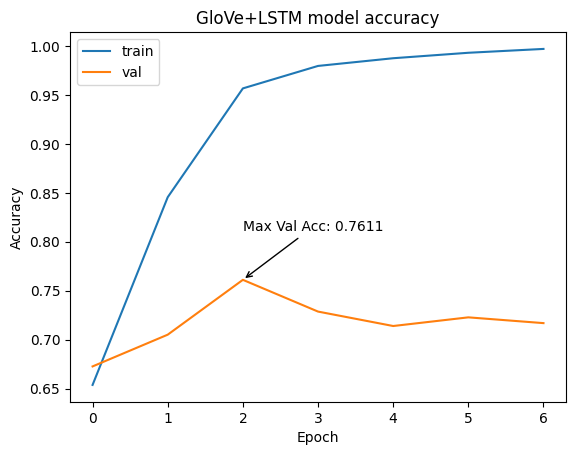

In [52]:
plot_train_val_acc(history, "GloVe+LSTM model accuracy", "accuracy")

In [138]:
saved_model = load_model('./best_model/best_model_lstm.h5')
# Classification report:
predicted = saved_model.predict(test_sequences)
y_predicted = np.argmax(predicted, axis=1)
print(classification_report(y_test, y_predicted))


Test Losss: 0.81954
Test accuracy: 75.75758%
46/46 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.66      0.69      0.68       183
           1       0.79      0.87      0.83       839
           2       0.73      0.56      0.63       430

    accuracy                           0.76      1452
   macro avg       0.73      0.71      0.71      1452
weighted avg       0.75      0.76      0.75      1452



# BERT Finetune

In [54]:
finBertTokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
finBert = TFBertModel.from_pretrained('ProsusAI/finbert')

distilBertTokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilBert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [99]:
def create_BERT_wrapper(bert_embeddings, max_len):
    input_ids = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="input_ids")
    input_mask = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="attention_mask")

    embeddings = bert_embeddings(input_ids, attention_mask=input_mask)[
        0]  # 0 = last hidden state, 1 = poller_output

    out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
    out = tf.keras.layers.Dense(128, activation='relu')(out)
    out = tf.keras.layers.Dropout(0.1)(out)
    out = tf.keras.layers.Dense(32, activation='relu')(out)

    y = tf.keras.layers.Dense(3, activation='softmax')(out)

    model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)

    model.layers[2].trainable = True
    # check https://stackoverflow.com/questions/60463829/training-tfbertforsequenceclassification-with-custom-x-and-y-data

    return model


In [56]:
def calculate_max_sentence_len(sentences, tokenizer):
    max_len = 0

    # For every sentence...
    for sent in sentences:

        # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
        input_ids = tokenizer.encode(sent, add_special_tokens=True)

        # Update the maximum sentence length.
        max_len = max(max_len, len(input_ids))

    return max_len

In [ ]:
"""def train_test_set(tokenizer):
    train_sentences, test_sentences, labels_train, labels_test = train_test_split(
        sentences, df['sentiment'], train_size=0.7, shuffle=True, random_state=42)

    max_len = min(calculate_max_sentence_len(train_sentences, tokenizer),
                  calculate_max_sentence_len(test_sentences, tokenizer))

    print('Max sentence length: ', max_len)

    X_train = tokenizer(
        text=train_sentences,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True)

    X_test = tokenizer(
        text=test_sentences,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True
    )
    # the same for attention mask
    print("\nTrain split shape: ", X_train['input_ids'].shape)
    print("\nTest split shape: ", X_test['input_ids'].shape)
    print(X_train['input_ids'])
    print(X_train['attention_mask'])

    return X_train, X_test, labels_train, labels_test, max_len """


In [ ]:
"""X_train, X_test, labels_train, labels_test, max_len_finBert = train_test_set(
    finBertTokenizer)"""


In [57]:
def train_test_set(tokenizer):
    max_len = calculate_max_sentence_len(sentences, tokenizer)
    print('Max sentence length: ', max_len)

    train_sentences, test_sentences, labels_train, labels_test = train_test_split(
    sentences, df['sentiment'], train_size=0.7, shuffle=True, random_state=42)

    X_train = {"input_ids" : [], "attention_mask" : []}
    X_test = {"input_ids" : [], "attention_mask" : []}

    for sentence in train_sentences:
        
            # `encode_plus` will:
            #    (1) Tokenize the sentence
            #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
            #    (3) Truncate/Pad sentence to max length
            #    (4) Map tokens to their IDs
            #    (5) Create attention mask
            #    (6) Return a dictionary of outputs

        encoded_sent = tokenizer.encode_plus(
            text=sentence,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=max_len,                  # Max length to truncate/pad
            padding='max_length',
            truncation=True,       # Pad sentence to max length
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='tf',
            verbose=True     # Return attention mask
        )

        # Add the outputs to the lists
        X_train["input_ids"].append(encoded_sent.get('input_ids'))
        X_train["attention_mask"].append(encoded_sent.get('attention_mask'))

    for sentence in test_sentences:  
        encoded_sent = tokenizer.encode_plus(
            text=sentence,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=max_len,                  # Max length to truncate/pad
            padding='max_length',
            truncation=True,       # Pad sentence to max length
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='tf',
            verbose=True     # Return attention mask
        )

        X_test["input_ids"].append(encoded_sent.get('input_ids'))
        X_test["attention_mask"].append(encoded_sent.get('attention_mask'))

    for key in ["input_ids", "attention_mask"]:
        X_train[key] = np.array(X_train[key])
        X_test[key] = np.array(X_test[key])
        X_train[key] = X_train[key].reshape(X_train[key].shape[0], max_len)
        X_test[key] = X_test[key].reshape(X_test[key].shape[0], max_len)

    # the same for attention mask
    print("\nTrain split shape: ", X_train['input_ids'].shape)
    print("\nTest split shape: ", X_test['input_ids'].shape)

    return X_train, X_test, labels_train, labels_test, max_len

In [58]:
X_train, X_test, labels_train, labels_test, max_len_finBert = train_test_set(finBertTokenizer)

Max sentence length:  111

Train split shape:  (3388, 111)

Test split shape:  (1452, 111)


# finBERT

In [61]:
model = create_BERT_wrapper(finBert, max_len_finBert)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=5e-05,  # HF recommendation
    epsilon=1e-08,
    clipnorm=1.0
)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 111)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 111)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 111,                                         

In [62]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('./best_model/finetuned_finbert.h5',
                     monitor='val_accuracy', mode='max', verbose=1,
                     save_best_only=True)

history = model.fit(x= {'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
                    y= tf.keras.utils.to_categorical(labels_train),
                    batch_size=32,
                    epochs=10,
                    validation_split=0.1,
                    callbacks=[es, mc])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


96/96 [==============================] - ETA: 0s - loss: 0.2932 - accuracy: 0.8868
Epoch 1: val_accuracy improved from -inf to 0.79941, saving model to ./best_model/finetuned_finbert.h5
96/96 [==============================] - 158s 989ms/step - loss: 0.2932 - accuracy: 0.8868 - val_loss: 0.5130 - val_accuracy: 0.7994
Epoch 2/10
96/96 [==============================] - ETA: 0s - loss: 0.1315 - accuracy: 0.9583
Epoch 2: val_accuracy improved from 0.79941 to 0.84661, saving model to ./best_model/finetuned_finbert.h5
96/96 [==============================] - 87s 906ms/step - loss: 0.1315 - accuracy: 0.9583 - val_loss: 0.4322 - val_accuracy: 0.8466
Epoch 3/10
96/96 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9787
Epoch 3: val_accuracy did not improve from 0.84661
96/96 [==============================] - 79s 826ms/step - loss: 0.0722 - accuracy: 0.9787 - val_loss: 0.5834 - val_accuracy: 0.7965
Epoch 4/10
96/96 [==============================] - ETA: 0s - loss: 0.04

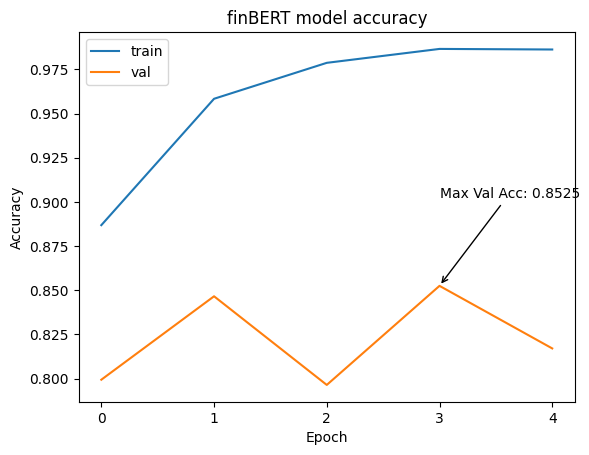

In [65]:
plot_train_val_acc(history, "finBERT model accuracy", "accuracy")

In [67]:
saved_model = load_model('./best_model/finetuned_finbert.h5',
                         custom_objects={"TFBertModel": TFBertModel})


In [68]:
# Classification report:
predicted = saved_model.predict(
    {'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
y_predicted = np.argmax(predicted, axis=1)
print(classification_report(labels_test, y_predicted))

46/46 [==============================] - 17s 265ms/step
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       183
           1       0.87      0.91      0.89       839
           2       0.83      0.77      0.80       430

    accuracy                           0.86      1452
   macro avg       0.85      0.83      0.84      1452
weighted avg       0.85      0.86      0.85      1452



In [135]:
# Example of prediction
def tokenize_sentence(sentence, tokenizer):
    tokenized_sentence = tokenizer.encode_plus(
        text=sentence,  # Preprocess sentence
        add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
        max_length=max_len_finBert,                  # Max length to truncate/pad
        pad_to_max_length=True,         # Pad sentence to max length
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='tf',
        verbose=True     # Return attention mask
    )
    return tokenized_sentence

tokenized_positive_sentence = tokenize_sentence(
    df[df['sentiment'] == 'positive']['headline'].values[0], finBertTokenizer)
tokenized_negative_sentence = tokenize_sentence(
    df[df['sentiment'] == 'negative']['headline'].values[0], finBertTokenizer)
tokenized_neutral_sentence = tokenize_sentence(
    df[df['sentiment'] == 'neutral']['headline'].values[0], finBertTokenizer)

predicted1 = saved_model.predict(
    {'input_ids': tokenized_positive_sentence['input_ids'], 'attention_mask': tokenized_positive_sentence['attention_mask']})
y_predicted1 = np.argmax(predicted1, axis=1)

print("Positive sentence prediction: ", le.inverse_transform(y_predicted1)[0])
print("Positive sentence true label: ",
      df[df['sentiment'] == 'positive']['sentiment'].values[0])
print("-"*50)

predicted2 = saved_model.predict(
    {'input_ids': tokenized_negative_sentence['input_ids'], 'attention_mask': tokenized_negative_sentence['attention_mask']})
y_predicted2 = np.argmax(predicted2, axis=1)

print("Negative sentence prediction: ", le.inverse_transform(y_predicted2)[0])
print("Negative sentence true label: ",
      df[df['sentiment'] == 'negative']['sentiment'].values[0])
print("-"*50)

predicted3 = saved_model.predict(
    {'input_ids': tokenized_neutral_sentence['input_ids'], 'attention_mask': tokenized_neutral_sentence['attention_mask']})
y_predicted3 = np.argmax(predicted3, axis=1)

print("Neutral sentence prediction: ", le.inverse_transform(y_predicted3)[0])
print("Neutral sentence true label: ",
      df[df['sentiment'] == 'neutral']['sentiment'].values[0])
print("-"*50)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 [==============================] - 0s 165ms/step
Positive sentence prediction:  positive
Positive sentence true label:  positive
--------------------------------------------------
1/1 [==============================] - 0s 134ms/step
Negative sentence prediction:  negative
Negative sentence true label:  negative
--------------------------------------------------
1/1 [==============================] - 0s 133ms/step
Neutral sentence prediction:  neutral
Neutral sentence true label:  neutral
--------------------------------------------------


# distilBERT

In [100]:
X_train, X_test, labels_train, labels_test, max_len_distilBert = train_test_set(distilBertTokenizer)

Max sentence length:  111

Train split shape:  (3388, 111)

Test split shape:  (1452, 111)


In [101]:
model = create_BERT_wrapper(distilBert, max_len_distilBert)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=5e-05,  # HF recommendation
    epsilon=1e-08,
    clipnorm=1.0
)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)

model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 111)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 111)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 111, 768),                                                   
                                 hidden_states=None                                        

In [102]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('./best_model/finetuned_distilbert.h5',
                     monitor='val_accuracy', mode='max', verbose=1,
                     save_best_only=True)

history = model.fit(x= {'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
                    y= tf.keras.utils.to_categorical(labels_train),
                    batch_size=32,
                    epochs=10,
                    validation_split=0.1,
                    callbacks=[es, mc])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


96/96 [==============================] - ETA: 0s - loss: 0.6039 - accuracy: 0.7383
Epoch 1: val_accuracy improved from -inf to 0.82596, saving model to ./best_model/finetuned_distilbert.h5
96/96 [==============================] - 90s 633ms/step - loss: 0.6039 - accuracy: 0.7383 - val_loss: 0.4203 - val_accuracy: 0.8260
Epoch 2/10
96/96 [==============================] - ETA: 0s - loss: 0.2907 - accuracy: 0.8967
Epoch 2: val_accuracy did not improve from 0.82596
96/96 [==============================] - 40s 412ms/step - loss: 0.2907 - accuracy: 0.8967 - val_loss: 0.4048 - val_accuracy: 0.8201
Epoch 3/10
96/96 [==============================] - ETA: 0s - loss: 0.1518 - accuracy: 0.9469
Epoch 3: val_accuracy did not improve from 0.82596
96/96 [==============================] - 42s 438ms/step - loss: 0.1518 - accuracy: 0.9469 - val_loss: 0.5192 - val_accuracy: 0.8260
Epoch 4/10
96/96 [==============================] - ETA: 0s - loss: 0.0843 - accuracy: 0.9698
Epoch 4: val_accuracy did not i

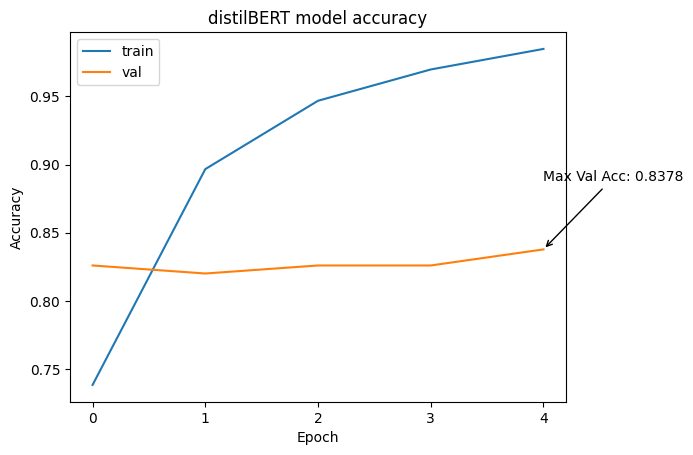

In [103]:
plot_train_val_acc(history, "distilBERT model accuracy", "accuracy")

In [104]:
saved_model = load_model('./best_model/finetuned_distilbert.h5',
                         custom_objects={"TFDistilBertModel": TFDistilBertModel})


In [109]:
from sklearn.metrics import accuracy_score
# Classification report:
predicted = saved_model.predict(
    {'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
y_predicted = np.argmax(predicted, axis=1)
print(classification_report(labels_test, y_predicted))

accuracy = accuracy_score(labels_test, y_predicted)
print(accuracy)

46/46 [==============================] - 6s 133ms/step
              precision    recall  f1-score   support

           0       0.87      0.78      0.82       183
           1       0.86      0.91      0.88       839
           2       0.81      0.75      0.78       430

    accuracy                           0.84      1452
   macro avg       0.84      0.81      0.83      1452
weighted avg       0.84      0.84      0.84      1452

0.8443526170798898


In [ ]:
# Example of prediction
def tokenize_sentence(sentence, tokenizer=distilBertTokenizer):
    tokenized_sentence = tokenizer.encode_plus(
        text=sentence,  # Preprocess sentence
        add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
        max_length=120,                  # Max length to truncate/pad
        pad_to_max_length=True,         # Pad sentence to max length        
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='tf',
        verbose=True     # Return attention mask
    )
    return tokenized_sentence

tokenized_positive_sentence = tokenize_sentence(df[df['sentiment']=='positive']['headline'].values[0])
tokenized_negative_sentence = tokenize_sentence(df[df['sentiment'] == 'negative']['headline'].values[0])
tokenized_neutral_sentence = tokenize_sentence(df[df['sentiment']=='neutral']['headline'].values[0])

predicted1 = saved_model.predict(
    {'input_ids': tokenized_positive_sentence['input_ids'], 'attention_mask': tokenized_positive_sentence['attention_mask']})
y_predicted1 = np.argmax(predicted1, axis=1)

print("Positive sentence prediction: ", le.inverse_transform(y_predicted1)[0])
print("Positive sentence true label: ", df[df['sentiment']=='positive']['sentiment'].values[0])
print("-"*50)

predicted2 = saved_model.predict(
    {'input_ids': tokenized_negative_sentence['input_ids'], 'attention_mask': tokenized_negative_sentence['attention_mask']})
y_predicted2 = np.argmax(predicted2, axis=1)

print("Negative sentence prediction: ", le.inverse_transform(y_predicted2)[0])
print("Negative sentence true label: ", df[df['sentiment']=='negative']['sentiment'].values[0])
print("-"*50)

predicted3 = saved_model.predict({'input_ids': tokenized_neutral_sentence['input_ids'], 'attention_mask': tokenized_neutral_sentence['attention_mask']})
y_predicted3 = np.argmax(predicted3, axis=1)

print("Neutral sentence prediction: ", le.inverse_transform(y_predicted3)[0])
print("Neutral sentence true label: ", df[df['sentiment']=='neutral']['sentiment'].values[0])
print("-"*50)
